In [3]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack

from mrf.display import display_single, SEG_CMAP

plt.rcParams['text.usetex'] = True

### First we download NGC 5907 images from CFHT Megacam, then bin them using 2*2 box and convolve with 1 pixel Gaussian

In [1]:
# Position of NGC 5907
ra, dec = 228.974042, 56.328771

In [ ]:
# Notice: the images might be very large (several Gb)!
from mrf import download
download.download_highres('n5907_df_g.fits', high_res='cfht', band='g')
download.download_highres('n5907_df_r.fits', high_res='cfht', band='r')

In [4]:
from mrf.celestial import Celestial
from astropy.convolution import convolve, Gaussian2DKernel
hdu = fits.open('CFHT_megapipe_img_G.fits')
cfht = Celestial(hdu[0].data, header=hdu[0].header)
hdu.close()
cfht.resize_image(0.5)
cfht.image = convolve(cfht.image, Gaussian2DKernel(1))
cfht.save_to_fits('ngc5907_cfht_g.fits')

In [29]:
hdu = fits.open('CFHT_megapipe_img_R.fits')
cfht = Celestial(hdu[0].data, header=hdu[0].header)
hdu.close()
cfht.resize_image(0.5)
cfht.image = convolve(cfht.image, Gaussian2DKernel(1))
cfht.save_to_fits('ngc5907_cfht_r.fits')

### Implement `mrf` task by providing directories of input images, along with galaxies you want to retain during `mrf`.

In [34]:
from mrf.task import MrfTask

In [54]:
task = MrfTask('ngc5907-task.yaml')
img_lowres = 'n5907_df_g.fits'
img_hires_b = 'ngc5907_cfht_g.fits'
img_hires_r = 'ngc5907_cfht_r.fits'
certain_gal_cat = 'gal_cat_n5907.txt'
results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, 
                   output_name='n5907', verbose=True)

2019-08-15 16:46:38,046 Running Multi-Resolution Filtering (MRF) on "cfht" and "df" images!
2019-08-15 16:46:38,062 Subtract BACKVAL=460.2 of Dragonfly image
2019-08-15 16:46:38,076 Magnify Dragonfly image with a factor of 3.0:
2019-08-15 16:46:39,414 Register high resolution image "ngc5907_cfht_g.fits" with "n5907_df_g.fits"
2019-08-15 16:46:48,495 Register high resolution image "ngc5907_cfht_r.fits" with "n5907_df_g.fits"
2019-08-15 16:46:57,247 Build flux models on high-resolution images: Blue band
2019-08-15 16:46:57,248     - sigma = 2.5, minarea = 2
2019-08-15 16:46:57,249     - deblend_cont = 0.00500, deblend_nthres = 32.0
2019-08-15 16:47:02,498     - Detect 41638 objects
2019-08-15 16:48:00,187 Build flux models on high-resolution images: Red band
2019-08-15 16:48:00,188     - sigma = 2.5, minarea = 2
2019-08-15 16:48:00,189     - deblend_cont = 0.00500, deblend_nthres = 32.0
2019-08-15 16:48:04,151     - Detect 35661 objects
2019-08-15 16:48:51,926 Make color correction to bl

### The results are stored in `results`. You can simply show the `mrf` results as follows. 

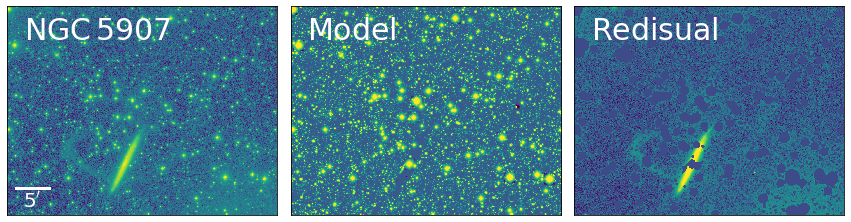

In [58]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 8))
ax1 = display_single(results.lowres_input.image, ax=ax1, pixel_scale=2.0, 
                     scale_bar_length=300, scale_bar_y_offset=0.3, 
                     add_text='NGC\, 5907', text_y_offset=0.65)
ax2 = display_single(results.lowres_model.image, ax=ax2, scale_bar=False, 
                     add_text='Model', text_y_offset=0.65)
ax3 = display_single(results.lowres_final.image, ax=ax3, scale_bar=False, 
                     add_text='Redisual', text_y_offset=0.65)
plt.subplots_adjust(wspace=0.05)
plt.savefig('n5907-demo.png', bbox_inches='tight', facecolor='silver')

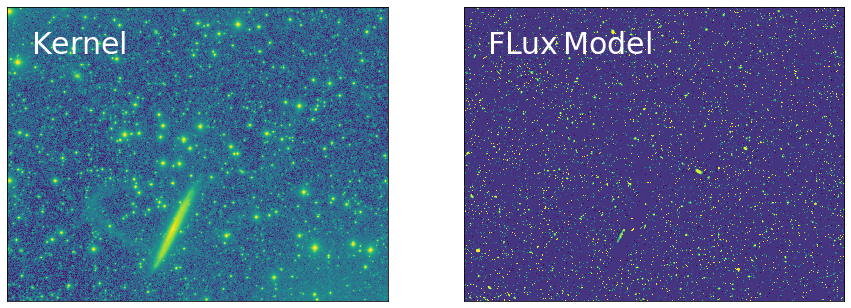

In [47]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 8))
ax1 = display_single(results.lowres_input.image, ax=ax1, 
                     scale_bar=False, add_text='Kernel', text_y_offset=0.65)
ax2 = display_single(results.hires_fluxmod, ax=ax2, scale='percentile', lower_percentile=0.5,
                     scale_bar=False, add_text='FLux\,Model', text_y_offset=0.65)

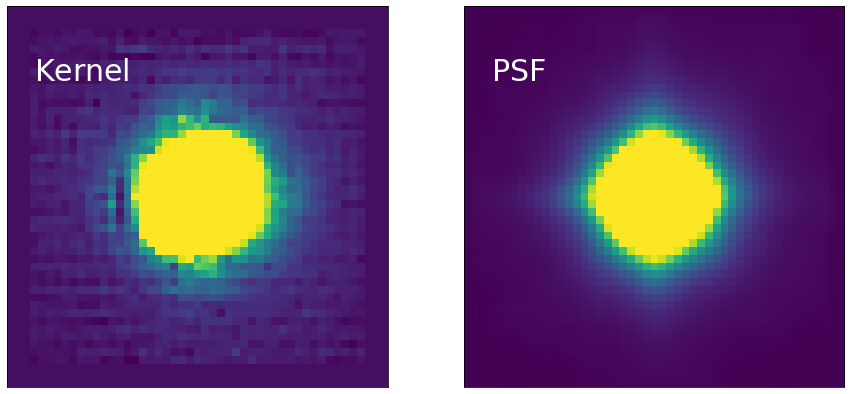

In [48]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 8))
ax1 = display_single(results.kernel_med, ax=ax1, 
                     scale_bar=False, add_text='Kernel')
ax2 = display_single(results.PSF, ax=ax2, 
                     scale_bar=False, add_text='PSF')